# Анализ данных пользователей сервиса GoFast

**Цель проекта** - оценка рентабельности подписки сервиса по данным о пользователях мобильного приложения

**Задачи:**
- Прочитать и проверить предоставленные файлы
- Сделать предобработку предоставленных данных о пользователях, их поездках и типах подписки
- Провести анализ данных (оценить средную длительность поездки, среднюю дальность поездки, соотношение пользователей с и без подписки, средний возраст пользователя
- Проверить гипотезы и дать ответ на вопрос "Выгодня ли сервису пользователи с платной подпиской"
- Помочь отделу маркетинга с рекламной компанией (оценить успешность и оптимальное число участников)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload
from scipy import stats as st
from math import sqrt

#### Загрузка данных

Мы имеем три файла для загрузки. Поэтому напише функцию для обработки их записи

In [3]:
def get_data(path):
    try:
        # Считываем данные
        data = pd.read_csv(path)
        # Выводим пять случайных строк для проверки корректности чтения
        print('Даннные были загружены успешно!\n\nПять случайных строк фрейма:')
        try:
            display(data.sample(n=5, random_state=789))
        except:
            display(data.head())
        # Выведем размер фрейма
        print(f'\nФрейм состоит из {data.shape[1]} признаков и {data.shape[0]} объектов')

        # Выводим общую информацию о фрейме
        print('\nОбщая информация о фрейме:')
        data.info()

        # Возвращаем фрейм
        return data
    except:
        print('Ошибка загрузки данных! Проверь корректность пути к файлу.')

Загрузим данные по пользователям в датафрейм users_raw_data.

In [4]:
users_raw_data = get_data('https://code.s3.yandex.net/datasets/users_go.csv')

Даннные были загружены успешно!

Пять случайных строк фрейма:


,user_id,name,age,city,subscription_type
379,380,Валерий,33,Сочи,ultra
947,948,Михаил,24,Пятигорск,free
398,399,Борис,30,Омск,ultra
410,411,Святослав,21,Краснодар,ultra
359,360,Одиссей,29,Омск,ultra



Фрейм состоит из 5 признаков и 1565 объектов

Общая информация о фрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


**Замечания по фрейму:**
- Возможны дубликаты. Следует особенно проверить признак `user_id`, так как его впоследствии можно использовать в качестве индекса
- Следует проверить неявные дубликаты в признаке `subscription_type`
- Следует проверить признак `age` на выбросы
- <span id='no_empty'>Пустот в фрейме нет

Аналогично поступим с данными по поездкам

In [5]:
rides_raw_data = get_data('https://code.s3.yandex.net/datasets/rides_go.csv')

Даннные были загружены успешно!

Пять случайных строк фрейма:


,user_id,distance,duration,date
15397,1347,5578.193767,25.918227,2021-08-19
11652,1075,4739.193322,21.478387,2021-11-24
15984,1388,5658.574533,14.317149,2021-06-13
4359,468,3228.356307,17.917906,2021-11-24
10923,1023,2346.581429,10.121517,2021-04-07



Фрейм состоит из 4 признаков и 18068 объектов

Общая информация о фрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


**Замечания по фрейму:**
- Возможны дубликаты. Следует особенно проверить признак `user_id`, так как его впоследствии можно использовать в качестве индекса
- <span id='date_type'>Следует преобразовать тип данных признака `date`
- Следует проверить признаки `distance` и `duration` на выбросы

Завершим загрузку данных фреймом о подписках

In [6]:
subscriptions_raw_data = get_data('https://code.s3.yandex.net/datasets/subscriptions_go.csv')

Даннные были загружены успешно!

Пять случайных строк фрейма:


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199



Фрейм состоит из 4 признаков и 2 объектов

Общая информация о фрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


**Замечаний по фрейму нет**

#### Предобработка данных

<span id='to_date'>Как отмечалось [выше](#date_type), необходимо преобразовать признак `date` в фрейме по поездкам к формату даты pandas

In [7]:
rides_raw_data['date'] = pd.to_datetime(rides_raw_data['date'],
                                        format='%Y-%m-%d')
# Проверка
rides_raw_data['date'].dtype

dtype('<M8[ns]')

<span id='added_month'>Теперь выделем столбец month, который будет содержать месяц поездки

In [8]:
rides_raw_data['month'] = rides_raw_data['date'].dt.month
# Проверим
rides_raw_data['month'].sample(5)

10532    12
5569      3
634       6
3695     11
17142     8
Name: month, dtype: int32

Проверим период, который есть у нас в фрейме. Выведем минимальный и максимальный месяц

In [9]:
print(f'Минимальный месяц в выборке {rides_raw_data["month"].min()}')
print(f'Максимальный месяц в выборке {rides_raw_data["month"].max()}')
print(f'Всего в выборке присутствуют данные за {len(rides_raw_data["month"].sort_values().unique())} месяцев')
print()
print(f'Промежуток в выборке представлен с {rides_raw_data["date"].min()} по {rides_raw_data["date"].max()}')

Минимальный месяц в выборке 1
Максимальный месяц в выборке 12
Всего в выборке присутствуют данные за 12 месяцев

Промежуток в выборке представлен с 2021-01-01 00:00:00 по 2021-12-30 00:00:00


Таким образом, мы имеем данные за полный год 2021

<span id='drop_dupl'>Пустот в фреймах [не обнаружено](#no_empty). Выведем количество дубликатов в фреймах по пользователям. Если в фрейме есть полные дубликаты - удалим их

In [10]:
users_duplicates = users_raw_data.duplicated().sum()
print(f'В фрейме о пользователей присутствует {users_duplicates} полных дубликатов')
if users_duplicates:
    users_raw_data = users_raw_data.drop_duplicates()
    # Проверка
    print(f'В фрейме о пользователей осталось {users_raw_data.duplicated().sum()} полных дубликатов')

В фрейме о пользователей присутствует 31 полных дубликатов
В фрейме о пользователей осталось 0 полных дубликатов


Проведем аналогичную проверку для фрейма с поездками

In [11]:
rides_duplicates = rides_raw_data.duplicated().sum()
print(f'В фрейме о пользователей присутствует {rides_duplicates} полных дубликатов')
if rides_duplicates:
    rides_raw_data = rides_raw_data.drop_duplicates()
    # Проверка
    print(f'В фрейме о пользователей осталось {rides_raw_data.duplicated().sum()} полных дубликатов')

В фрейме о пользователей присутствует 0 полных дубликатов


**Вывод шага:** была проведена предобработка данных:
- [Приведен](#to_date) тип признака date в фрейме по поездкам к типу datetime
- [Добавлен](#added_month) столбец month (понадобится в дальнейшем исследовании для агрегирования по группам)
- Были [обработаны](#drop_dupl) полные дубликаты в двух фреймах

#### Исследовательский анализ данных

**Найдем частоту встречаемости городов**. Для этого воспользуемся методом value_counts() для столбца city в фрейме по пользователям.

In [12]:
users_raw_data['city'].value_counts().sort_values(ascending=False)

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: count, dtype: int64

Визуализируем данные

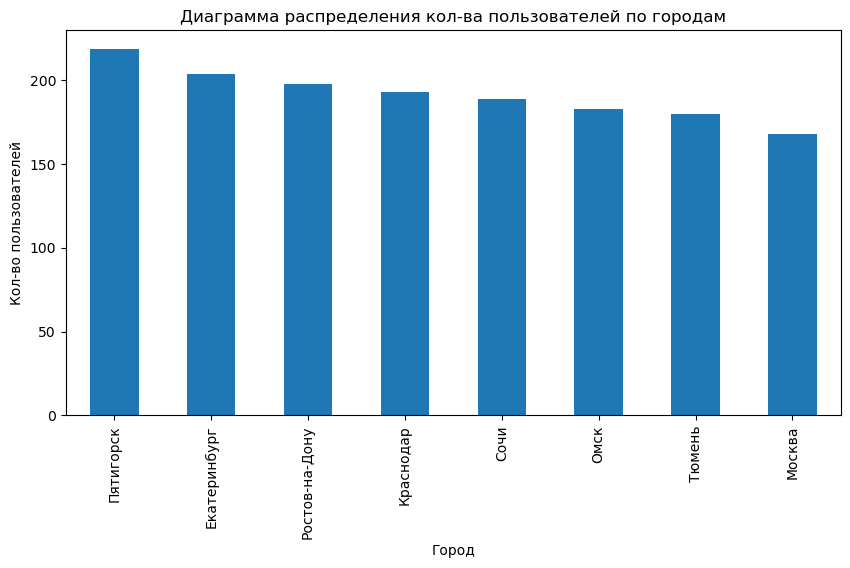

In [13]:
(
    users_raw_data['city'].value_counts()
                          .sort_values(ascending=False)
                          .plot(kind="bar",
                                title='Диаграмма распределения кол-ва пользователей по городам',
                                figsize=(10, 5),
                                ylabel='Кол-во пользователей',
                                xlabel='Город')
)

plt.show()

**Вывод:** По таблице видно, что больше всего пользователей находится в городе Пятигорск, меньше всего - в Москве.
По графику же видно, что доля городов в общей выборке относительно одинаковая

Оценим количество и доли пользователей с разными типами подписок

In [14]:
users_raw_data['subscription_type'].value_counts().sort_values()

subscription_type
ultra    699
free     835
Name: count, dtype: int64

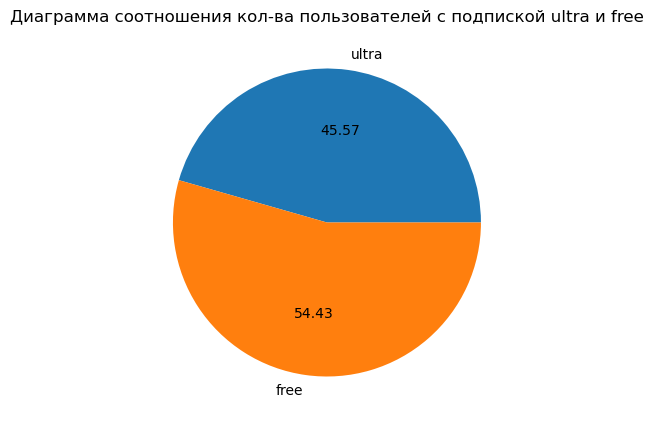

In [15]:
(
    users_raw_data['subscription_type'].value_counts()
                                     .sort_values()
                                     .plot(kind="pie",
                                           title='Диаграмма соотношения кол-ва пользователей с подпиской ultra и free',
                                           figsize=(10, 5),
                                           autopct='%.2f',
                                           ylabel="")
)

plt.show()

Видно, что пользователей без подписки больше половины всего числа пользователей

Для данного параметра мы создадим гистограмму распределения возраста пользователей, по которой сделаем выводы

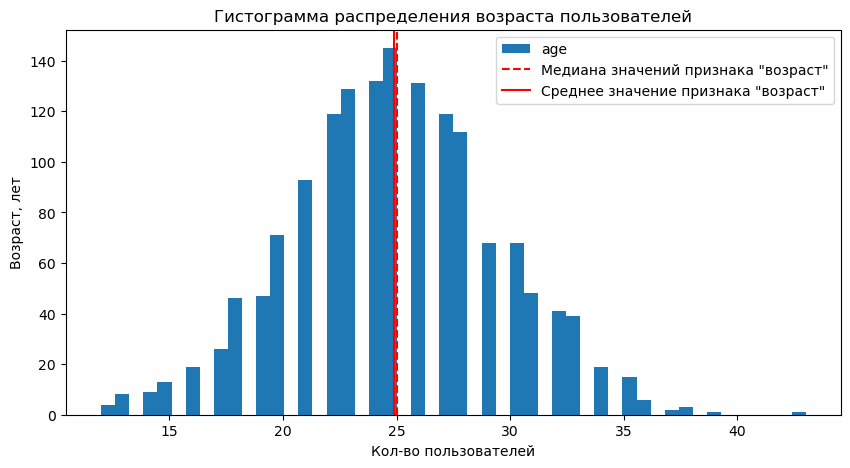

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

In [16]:
# Гистограмма распределения
ax = (
    users_raw_data['age'].sort_values()
                         .plot(kind="hist",
                               bins=50,
                               ylabel='Возраст, лет',
                               xlabel='Кол-во пользователей',
                               title='Гистограмма распределения возраста пользователей',
                               figsize=(10, 5))
)
# Вертикальная линия медианного значения
ax.axvline(users_raw_data['age'].median(),
                           color='red',
                           linestyle='--',
                           label='Медиана значений признака "возраст"')

# Вертикальная линия среднего значения
ax.axvline(users_raw_data['age'].mean(),
                color='red',
                linestyle='-',
                label='Среднее значение признака "возраст"')

plt.legend()

plt.show()

users_raw_data['age'].describe()

На графике видны несколько выбросов, но они не сильно влияют на выборку, что видно по близкому среднему и медианному значению возраста

Оценим дальность поездки. Для данного признака я переведу данные в км (с 2 знаками после запятой). По этим данным можно будет построить Гистограмму - по x отложим расстояние, по y - кол-во поездок

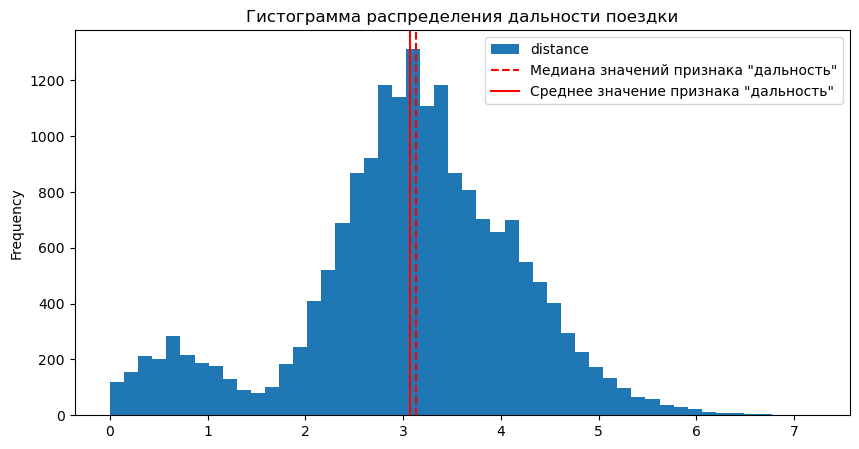

count    18068.000000
mean         3.070649
std          1.116847
min          0.000000
25%          2.540000
50%          3.130000
75%          3.780000
max          7.210000
Name: distance, dtype: float64

In [17]:
distance_converted = (rides_raw_data['distance'] / 1000).round(2)

ax = (
    distance_converted.sort_values()
                      .plot(kind="hist",
                            bins=50,
                            title='Гистограмма распределения дальности поездки',
                            figsize=(10, 5))
)
# Вертикальная линия медианного значения
ax.axvline(distance_converted.median(),
                           color='red',
                           linestyle='--',
                           label='Медиана значений признака "дальность"')

# Вертикальная линия среднего значения
ax.axvline(distance_converted.mean(),
                color='red',
                linestyle='-',
                label='Среднее значение признака "дальность"')

plt.legend()

plt.show()

distance_converted.describe()

По данному графику можно отметить, что есть два варианта поездок - на короткие дистанции (до 1 км) и на длинные (в среднем 3 км). Следует проверить такую гипотезу на параметре "duration". Сейчас же стоит посчитать среднюю поездку пользователя и изучить распределение

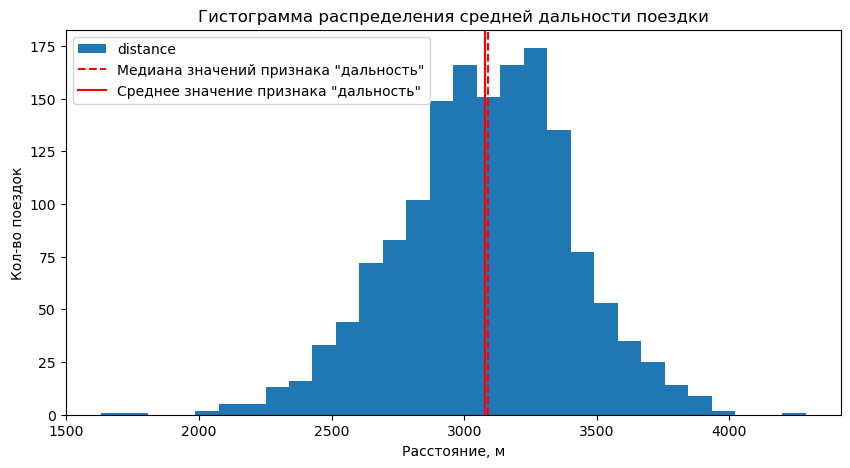

,distance
count,1534.000000
mean,3077.296650
std,327.624403
min,1630.788427
25%,2882.505704
50%,3090.864050
75%,3293.325678
max,4287.519387


In [18]:
mean_user_distance = rides_raw_data.pivot_table(index="user_id",
                                                values='distance',
                                                aggfunc='mean')

ax = (mean_user_distance.plot(kind="hist",
                              bins=30,
                              xlabel='Расстояние, м',
                              ylabel='Кол-во поездок',
                              title='Гистограмма распределения средней дальности поездки',
                              figsize=(10, 5))
)

# Вертикальная линия медианного значения
ax.axvline(mean_user_distance.distance.median(),
                           color='red',
                           linestyle='--',
                           label='Медиана значений признака "дальность"')

# Вертикальная линия среднего значения
ax.axvline(mean_user_distance.distance.mean(),
                color='red',
                linestyle='-',
                label='Среднее значение признака "дальность"')

plt.legend()

plt.show()

mean_user_distance.describe()

Гистограмма средней дальности поездки пользователя похожа на нормальное распределение с вершиной 3 км

Проведем аналогичные параметру "distance" исследования по продолжительности поездок

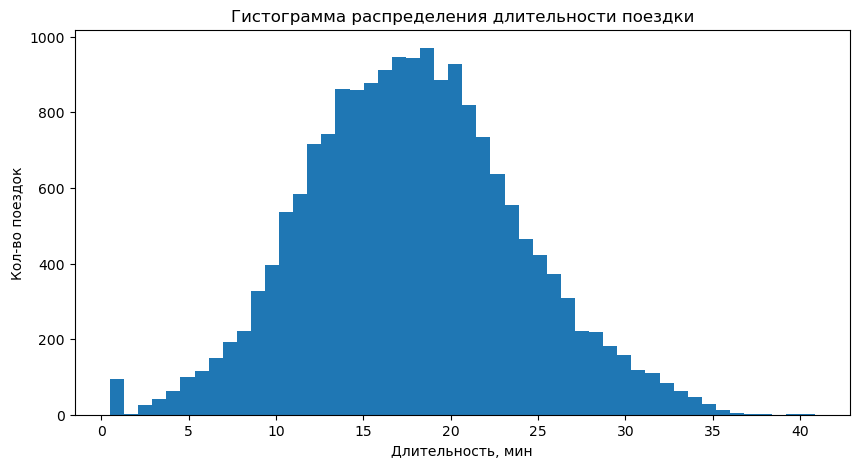

In [19]:
(
    rides_raw_data['duration'].sort_values()
                              .plot(kind="hist",
                                    bins=50,
                                    title='Гистограмма распределения длительности поездки',
                                    figsize=(10, 5))
)
plt.xlabel('Длительность, мин')
plt.ylabel('Кол-во поездок')

plt.show()

Гистограмма выглядит как нормальное распределение<br>
Есть выброс около нуля, стоит детальнее проверить эти данные

In [20]:
rides_raw_data.query('duration < 2')

,user_id,distance,duration,date,month
6531,701,4196.445201,0.5,2021-08-31,8
6570,704,4830.824371,0.5,2021-10-14,10
6680,712,4684.004397,0.5,2021-03-04,3
6695,713,5215.642710,0.5,2021-02-25,2
6768,718,5197.436649,0.5,2021-02-11,2
...,...,...,...,...,...
17004,1460,5531.335845,0.5,2021-01-19,1
17242,1477,6724.932981,0.5,2021-01-12,1
17314,1483,4445.481070,0.5,2021-03-06,3
17505,1496,5722.551787,0.5,2021-02-14,2


Эти данные стоит заменить. Мы можем вычислить среднюю скорость поездок и через это заменить длительности поездок ошибочных данных

In [21]:
# Фрейм с корректными данными длительности поездок
rides_correct_data = rides_raw_data.query('duration >= 2')
# Средняя скорость (расстояние / время)
avg_velocity = (rides_correct_data['distance'] / rides_correct_data['duration']).mean()
# Замена неверных значений
rides_raw_data.loc[rides_raw_data['duration'] < 2, 'duration'] = rides_raw_data.loc[rides_raw_data['duration'] < 2, 'distance'] / avg_velocity
# Проверка
rides_raw_data.query('duration < 2')['user_id'].count()

0

Таким образом мы избавились от некорректных данных.<br>
Выведем график еще раз

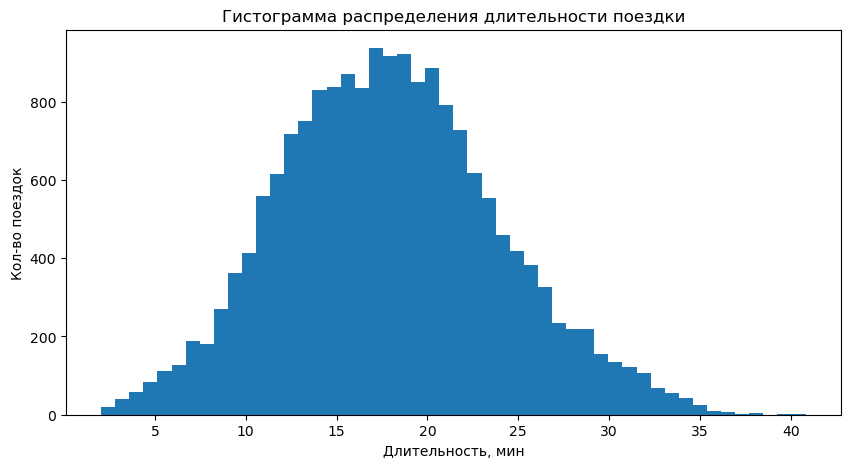

In [22]:
(
    rides_raw_data['duration'].sort_values()
                              .plot(kind="hist",
                                    bins=50,
                                    title='Гистограмма распределения длительности поездки',
                                    figsize=(10, 5))
)
plt.xlabel('Длительность, мин')
plt.ylabel('Кол-во поездок')

plt.show()

По итогу график напоминает нормальное распределение.
Вычислим среднее и медианное время в пути

In [23]:
print(f'Средняя длительность поездки: {rides_raw_data["duration"].mean():.2f} мин')
print(f'Медианный длительность поездки: {rides_raw_data["duration"].median():.2f} мин')

Средняя длительность поездки: 17.95 мин
Медианный длительность поездки: 17.75 мин


Медианное и среднее значения близки, что говорит об однородной выборке

<b>Таким образом мы видим, что выборка получается довольно однородной.<br>

Мы также нашли и обработали аномалии в стольце duration фрейма по поездкам</b>

#### Объединение данных

Объединим данные трех фреймов в один общий (total_data)

In [24]:
total_data = (
    users_raw_data.merge(subscriptions_raw_data,
                         on='subscription_type',
                         how='outer')
).merge(rides_raw_data,
        on='user_id',
        how='outer')

# Проверка
total_data.head()

,user_id,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,6,0,199,4409.919140,25.599769,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,6,0,199,2617.592153,15.816871,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,6,0,199,754.159807,6.232113,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,6,0,199,2694.783254,18.511000,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,6,0,199,4028.687306,26.265803,2021-08-28,8


Проверим кол-во строк новой таблице. Оно должно равнятся кол-ву строк в фрейме по поездкам

In [25]:
if total_data['user_id'].count() == rides_raw_data['user_id'].count():
    print('Объудинение прошло успешно')
else:
    print('Есть ошибка, проверь объединение')

Объудинение прошло успешно


Выделим две группы (отдельных фрейма) - под пользователей с и без подписки

In [26]:
ultra_subs_data = total_data.query('subscription_type == "ultra"')
# Проверка
ultra_subs_data.head()

,user_id,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,6,0,199,4409.919140,25.599769,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,6,0,199,2617.592153,15.816871,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,6,0,199,754.159807,6.232113,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,6,0,199,2694.783254,18.511000,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,6,0,199,4028.687306,26.265803,2021-08-28,8


In [27]:
free_subs_data = total_data.query('subscription_type == "free"')
# Проверка
free_subs_data.head()

,user_id,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,distance,duration,date,month
6500,700,Айдар,22,Омск,free,8,50,0,2515.690719,14.944286,2021-01-02,1
6501,700,Айдар,22,Омск,free,8,50,0,846.932642,16.234663,2021-02-01,2
6502,700,Айдар,22,Омск,free,8,50,0,4004.434142,20.016628,2021-02-04,2
6503,700,Айдар,22,Омск,free,8,50,0,1205.911290,9.782872,2021-02-10,2
6504,700,Айдар,22,Омск,free,8,50,0,3047.379435,17.427673,2021-02-14,2


Создадим график распределения дистанции поездки для каждой группы

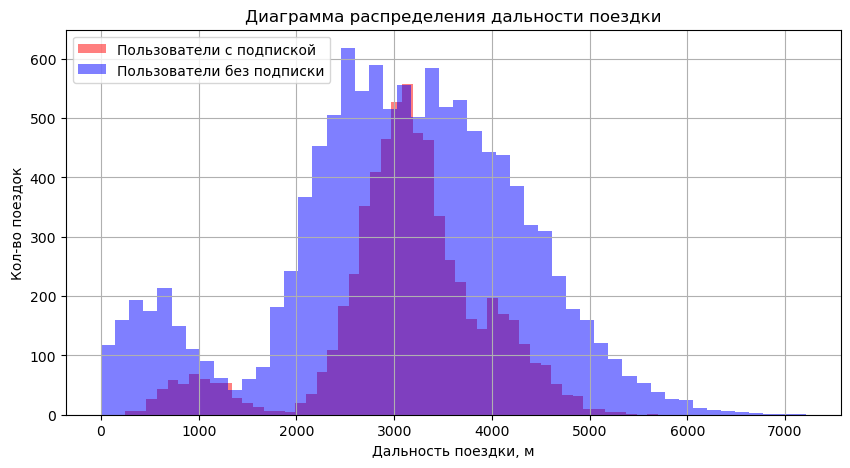

In [28]:
ultra_subs_data['distance'].plot(
    kind='hist',
    bins=50,
    color="red",
    alpha=0.5,
    label='Пользователи с подпиской'
)

free_subs_data['distance'].plot(
    kind='hist',
    bins=50,
    grid=True,
    figsize=(10, 5),
    color="blue",
    alpha=0.5,
    title="Диаграмма распределения дальности поездки",
    label='Пользователи без подписки'
)

plt.xlabel('Дальность поездки, м')
plt.ylabel('Кол-во поездок')
plt.legend(loc="upper left")

plt.show()

По графику видно, что пользователи без подписки чаще, чем пользователи с подпиской, арендуют самокаты на короткие дистанции (до 1 км). Также стоит отметить визуальную схожесть графиков (одинаковая форма). Еще я заметил, что у обоих графиков есть две вершины (как я и заметил выше, для обще выборки)

Проведем аналогичные исследования длительности поездки

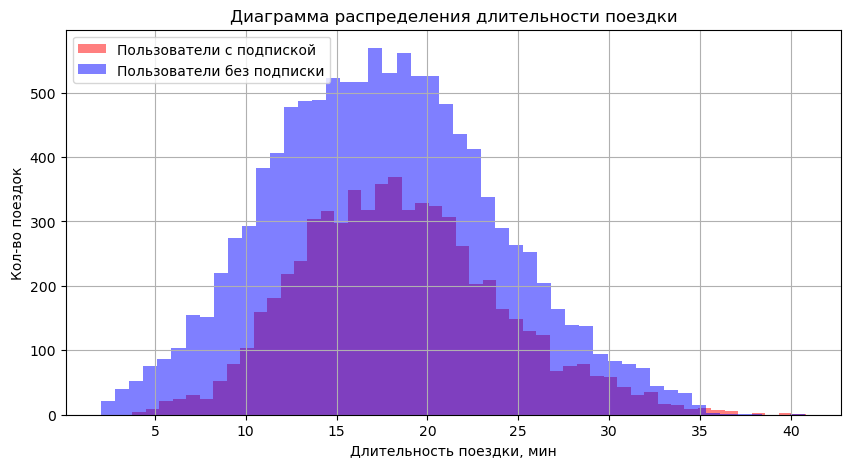

In [29]:
ultra_subs_data['duration'].plot(
    kind='hist',
    bins=50,
    color="red",
    alpha=0.5,
    label='Пользователи с подпиской'
)

free_subs_data['duration'].plot(
    kind='hist',
    bins=50,
    grid=True,
    figsize=(10, 5),
    color="blue",
    alpha=0.5,
    title="Диаграмма распределения длительности поездки",
    label='Пользователи без подписки'
)

plt.xlabel('Длительность поездки, мин')
plt.ylabel('Кол-во поездок')
plt.legend(loc="upper left")

plt.show()

Опять же видна визуальная схожесть обоих графиков. Оба графика напоминают нормальное распределение.<br>
По графикам выше видно, что группы имеют одинаковое поведение (графики выглядят одинаково)

<b>Я объединил три фрейма в один общий, который в последующем разбил на два - по типу подписки.
Я исследовал распределение длительности и длальности пути, по графикам выше видно, что распределения для обеих групп однородные</b>

#### Подсчёт выручки

Округлим столбец duration в фрейме total_data

In [30]:
total_data['duration_rounded'] = np.ceil(total_data['duration'])
# Проверка
total_data['duration_rounded'].head()

0    26.0
1    16.0
2     7.0
3    19.0
4    27.0
Name: duration_rounded, dtype: float64

Создадим фрейм на основе объединенного фрейма total_data. Для этого создам воспользуюсь методом groupby()

In [31]:
pivot_table = (total_data.groupby(['month', 'user_id', 'subscription_type'])
                        .aggregate({
                                    'distance':'sum',
                                    'duration_rounded':'sum',
                                    'user_id': 'count',
                                    'minute_price': 'max',
                                    'start_ride_price':'max',
                                    'subscription_fee':'max',
                                 }))
pivot_table.columns = ['total_distance', 'total_duration', 'total_rides', 'price_per_minute', 'price_per_ride', 'price_per_month']
pivot_table = pivot_table.reset_index()
# Проверка
pivot_table

,month,user_id,subscription_type,total_distance,total_duration,total_rides,price_per_minute,price_per_ride,price_per_month
0,1,1,ultra,7027.511294,42.0,2,6,0,199
1,1,3,ultra,3061.777147,13.0,1,6,0,199
2,1,5,ultra,3914.646990,13.0,1,6,0,199
3,1,7,ultra,6478.080979,28.0,2,6,0,199
4,1,12,ultra,3577.151148,33.0,1,6,0,199
...,...,...,...,...,...,...,...,...,...
11326,12,1525,free,4597.854350,34.0,1,8,50,0
11327,12,1526,free,3644.121544,23.0,1,8,50,0
11328,12,1528,free,3998.569324,11.0,1,8,50,0
11329,12,1532,free,6111.889853,42.0,2,8,50,0


Теперь посчитаем итоговую цену за месяц по формуле:<br>
<i>total_rides * price_per_ride + total_duration * price_per_minute + price_per_month</i>

In [32]:
pivot_table['total_price'] =(
    pivot_table['total_rides'] * pivot_table['price_per_ride'] +        # цена за старт поездки
    pivot_table['total_duration'] * pivot_table['price_per_minute'] +   # цена за длительность поездки
    pivot_table['price_per_month']                                      # цена за подписку
)
# Вывод результата/проверка
pivot_table[['month', 'user_id', 'total_price']]

,month,user_id,total_price
0,1,1,451.0
1,1,3,277.0
2,1,5,277.0
3,1,7,367.0
4,1,12,397.0
...,...,...,...
11326,12,1525,322.0
11327,12,1526,234.0
11328,12,1528,138.0
11329,12,1532,436.0


Таким образом мы получили прибыль с каждого пользователя помесячно.

#### Проверка гипотез

Для всех исследований гипотез мы будем использовать уровень значимости 5% 

In [33]:
alpha = .05

Также для оптимизации кода создадим функцию, которая будет делать вывод результата

In [34]:
def hypothesis_res(pvalue):
    print('p-значение:', pvalue)

    if pvalue < alpha:
        print('Нулевая гипотеза не подтвердилась, выбираем альтернативную гипотезу')
    else:
        print('Не получилось отвергнуть нулевую гипотезу') 

<b>1. Нулевая гипотеза:</b> <i>Средняя длительность поездок пользователей с подпиской равна средней длительности поездко пользователей без подписки</i><br>
<b>Альтернативная гипотеза:</b> <i>Средняя длительность поездок пользователей с подпиской больше средней длительности поездко пользователей без подписки</i><br>

Для этого воспользуемся т-тестом для односторонней гипотезы.<br><br>
Будем использовать выборки, которые мы получили на шаге 4 (ultra_subs_data и free_subs_data). Я предполагаю, что дисперсии у них равны (можно увидеть на графике).

In [35]:
hypothesis_res(
    st.ttest_ind(ultra_subs_data['duration'], 
                 free_subs_data['duration'],
                 alternative='greater')
      .pvalue
) 

p-значение: 3.4062883651171046e-23
Нулевая гипотеза не подтвердилась, выбираем альтернативную гипотезу


Таким образом, делаем выбор в пользу <b>альтернативной гипотезы - Средняя длительность поездок пользователей с подпиской больше средней длительности поездко пользователей без подписки

<b>2. Нулевая гипотеза:</b> <i>Пользователи с подпиской за одну сессию проезжают 3130 метров</i><br>
<b>Альтернативная гипотеза:</b> <i>пользователи с подпиской за одну сессию проезжают более 3130 метров</i><br>

Для этого воспользуемся т-тестом для односторонней гипотезы.<br><br>
Будем использовать выборку пользователей с подпиской

In [36]:
route_length = 3130
hypothesis_res(
    st.ttest_1samp(ultra_subs_data['distance'], 
                   route_length,
                   alternative='greater')
      .pvalue
) 

p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


Таким образом, делаем выбор в пользу <b>оригинальной гипотезы - Пользователи с подпиской за одну сессию проезжают 3130 метров или менее</b>

<b>3. Нулевая гипотеза:</b> <i>Выручка от пользователей с подпиской равна выручке пользователей без подписки</i><br>
<b>Альтернативная гипотеза:</b> <i>Выручка от пользователей с подпиской выше выручки пользователей без подписки</i><br>

Для этого воспользуемся т-тестом для односторонней гипотезы.<br><br>
Будем брать сводные данные, собранные на шаге 5

In [37]:
hypothesis_res(
    st.ttest_ind(pivot_table.query('subscription_type == "ultra"')['total_price'], 
                 pivot_table.query('subscription_type == "free"')['total_price'],
                 alternative='greater')
      .pvalue
)

p-значение: 5.937346250845203e-26
Нулевая гипотеза не подтвердилась, выбираем альтернативную гипотезу


Таким образом, делаем выбор в пользу <b>альтернативной гипотезы - Пользователи с подпиской приносят больше выручки</b>

#### Распределения

Для перовй задачи мы будем использовать аппроксимацию биномиального распределения нормальным распределением и метод CDF.<br>
Создадим цикл, который будет увеличивать число получателей промокодов, пока план была примерно 5 %

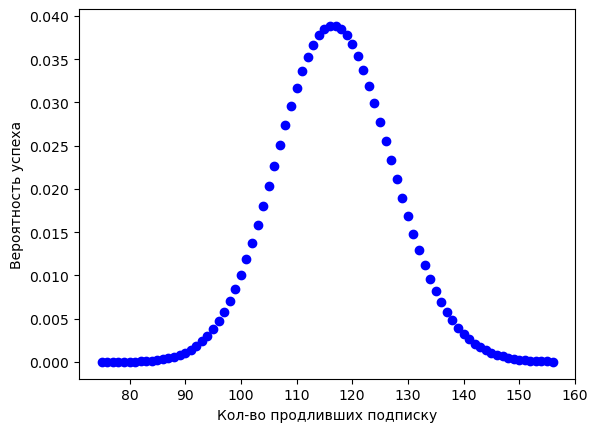

Ответ: Нужно раздать минимально 1169 промокодов, чтобы 100 человек продлили акцию (Верятность не выполнить план: 4.97%)


In [38]:
p = 0.1                 # Вероятность приобрести подписку
plan = 100              # Плановое кол-во продливателей подписки
threshold = .05         # Шанс не выполнить план
n = 0                   # Начальное число получателей
current_prob = 1        # Текущая вероятность не выпонить план

while current_prob > threshold:
    n += 1
    mu = n * p
    sigma = sqrt(n * p * (1 - p))
    distr = st.norm(mu, sigma)
    current_prob = distr.cdf(plan)
    
left = int(n * p - 4 * sqrt(n * p * (1 - p)))
right = int(n * p + 4 * sqrt(n * p * (1 - p)))

x = list(range(max(0, left), right))

ax = plt.plot(x,
              st.binom.pmf(x, n, p),
              'bo')



plt.xlabel('Кол-во продливших подписку')
plt.ylabel('Вероятность успеха')

plt.show()   
print(f'Ответ: Нужно раздать минимально {n} промокодов, чтобы 100 человек продлили акцию (Верятность не выполнить план: {current_prob:.2%})')

Для второй задачи также воспользуемся апроксимацией и методом CDF.

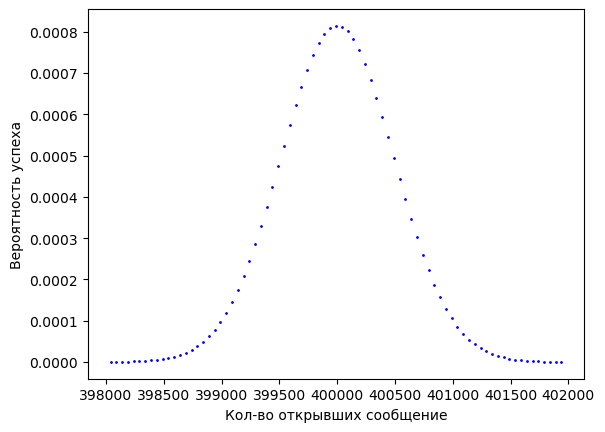

Ответ: Вероятность, что сообщение откроет не более 399500.0 человек состовляет 15.37%


In [39]:
n = 10**6                  # Общее число получателей
p = .4                     # Вероятность успеха (пользователь откроет сообщение)
threshold = 399.5 * 10**3  # Максимальное число открывших

mu = n * p
sigma = sqrt(n * p * (1 - p))
distr = st.norm(mu, sigma)
threshold_prob = distr.cdf(threshold)

left = int(n * p - 4 * sqrt(n * p * (1 - p)))
right = int(n * p + 4 * sqrt(n * p * (1 - p)))

x = list(range(max(0, left), right, 50))

ax = plt.plot(x,
              st.binom.pmf(x, n, p),
              'bo',
              ms=1)



plt.xlabel('Кол-во открывших сообщение')
plt.ylabel('Вероятность успеха')

plt.show()   
print(f'Ответ: Вероятность, что сообщение откроет не более {threshold} человек состовляет {threshold_prob:.2%}')

**Итоговый вывод по работе:**

В данной работе были проанализированы данные по пользователям, их поездкам и типам подписок<br>
Была проведена предобработка данных (убраны дубликаты, изменены типы столбцов дат, добавлены новые столбцы месяца поездки)<br>
Был проведен исследовательский анализ данных. Вот его результаты:<br>
- Больше всего пользователей находится в городе Пятигорск, меньше всего - в Москве. Однако стоит отметить, что доля городов в общей выборке относительно одинаковая
- Пользователей без подписки больше половины всего числа пользователей
- Средний возраст пользователей: 25 лет
- Существет два основных варианта поездок: короткие - до близжайшей необходиой точки - и долгие - прогулочные/экскурсионные
- Средняя дальность поездки - около 3 км
- Средняя длительность поездки - 18 мин

Для дальнейшего статистического анализа три исходных фрейма были объединены в один и разбиты на два - по типу подписки.<br>
На основании двух групп были сделаны следующие выводы:
- Обе группы разделяют схожее поведение
- Пользователи с подпиской приносят компании больше выручки. Связано это отчасти с тем, что средняя продолжительность поездки пользователей с подпиской больше средней продолжительности поездки пользователей без подписки
- В среднем пользователи с подпиской проезжают не более 3130 метров

Был проведен статистический анализ для отдела маркетинга.<br>
Было выявлено оптимальное кол-во получателей промоакции - необходимо разослать 1169 акций, чтобы привлечб как минимум 100 человек (вероятность провала составляет 5%)<br>
Также если будет запущено 1 млн push-уведомлений, то с вероятностью 15,37% их откроет не более 399,5 тыс человек

Рекомендации по сбору информации:
- Проверить уникальных пользователей (в выборке присутствовало 36 дублирующихся пользователя)
- Проверить корректность вычисления времени поездки (были найдены записи с большой дистанцией и временем поездки 0.5 минут)